# The Art of Dataset Design: How to Build Tables That Support Any Analysis

## Imports

In [20]:
import sqlite3
import random
import time
import pandas as pd
from datetime import datetime, timedelta

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Step 0: Create mock event data

In [21]:
# Create a connection and a cursor
!rm events.db
conn = sqlite3.connect('events.db')
cursor = conn.cursor()

# Create the `facts.events` table

cursor.execute('''drop table if exists events''')
cursor.execute('''CREATE TABLE IF NOT EXISTS events
                 (timestamp TEXT, user_id INTEGER, event_name TEXT, value REAL)''')

# Generate events for 100 users
event_types = ["login", "create_todo", "complete_todo", "move_todo", "delete_todo", "view_ad", "revenue"]
num_users = 100
num_days = 180

# Helper function to generate random date within the last 180 days
def random_date():
    end_date = datetime.now()
    start_date = end_date - timedelta(days=num_days)
    random_seconds = random.randint(0, int((end_date - start_date).total_seconds()))
    return start_date + timedelta(seconds=random_seconds)

def random_time(date):
    return date + timedelta(seconds = random.randint(0, 3600 * 24))

for user_id in range(1, num_users + 1):
    # Generate a different number of events for each user
    engagement = random.random()
    num_events = random.randint(10, 150)
    signup_date = random_date()
    for i in range(num_days):
        date = signup_date + timedelta(i)
        if random.random() > engagement:
            for _ in range(1 + int(engagement * 10)):
                timestamp = random_time(date).strftime("%Y-%m-%d %H:%M:%S")
                event_name = random.choice(event_types)

                if event_name == "revenue":
                    value = round(random.uniform(0.5, 50), 2)
                else:
                    value = None

                cursor.execute("INSERT INTO events (timestamp, user_id, event_name, value) VALUES (?, ?, ?, ?)", (timestamp, user_id, event_name, value))

# Commit the changes and close the connection
conn.commit()



In [22]:
pd.read_sql_query("SELECT * FROM events limit 10", conn)

,timestamp,user_id,event_name,value
0,2022-11-14 08:09:51,1,move_todo,NaN
1,2022-11-14 04:31:59,1,login,NaN
2,2022-11-14 01:13:54,1,view_ad,NaN
3,2022-11-14 08:48:52,1,move_todo,NaN
4,2022-11-14 01:58:45,1,revenue,27.58
5,2022-11-14 08:51:28,1,complete_todo,NaN
6,2022-11-15 21:18:47,1,revenue,11.90
7,2022-11-16 02:40:55,1,view_ad,NaN
8,2022-11-16 13:30:49,1,login,NaN
9,2022-11-16 00:55:01,1,login,NaN


<Axes: >

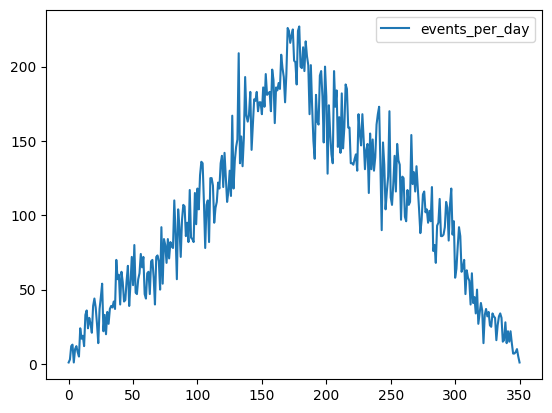

In [27]:
pd.read_sql_query("SELECT date(timestamp) as date, count(1) as events_per_day FROM events group by 1 order by 1", conn).plot()

## Step 1: Create aggregated events per day and user

In [28]:
conn.execute('drop table if exists daily_events')
conn.execute("""
create table daily_events as
SELECT
user_id,
date(timestamp) as date,
count(case when event_name ='login' then 1 end) as login,
count(case when event_name ='create_todo' then 1 end) as create_todo,
count(case when event_name ='complete_todo' then 1 end) as complete_todo,
count(case when event_name ='move_todo' then 1 end) as move_todo,
count(case when event_name ='delete_todo' then 1 end) as delete_todo,
count(case when event_name ='view_ad' then 1 end) as view_ad,
coalesce(sum(case when event_name ='revenue' then value end), 0) as revenue
from events
group by 1,2
""");

In [29]:
pd.read_sql_query("select * from daily_events limit 10", conn)

,user_id,date,login,create_todo,complete_todo,move_todo,delete_todo,view_ad,revenue
0,1,2022-11-14,1,0,1,2,0,1,27.58
1,1,2022-11-15,0,0,0,0,0,0,11.90
2,1,2022-11-16,3,1,0,0,0,1,0.00
3,1,2022-11-17,1,0,1,1,0,0,0.00
4,1,2022-11-18,0,0,1,1,1,0,0.00
5,1,2022-11-19,2,0,0,3,0,0,21.09
6,1,2022-11-20,0,2,0,2,0,0,51.71
7,1,2022-11-23,1,1,1,0,0,1,50.73
8,1,2022-11-25,0,1,0,0,1,0,0.00
9,1,2022-11-26,2,1,0,0,0,3,0.00


## Step 2: Create signals dataset

In [49]:
conn.execute('drop table if exists signals')
pd.read_sql_query("""
WITH RECURSIVE
    -- Create a list of consecutive dates
    dates (date) AS (
        SELECT date(julianday('now') - 179)
        UNION ALL
        SELECT date(julianday(date) + 1)
        FROM dates
        WHERE date < date('now')
    ),
    -- Create a list of unique users
    users AS (
        SELECT user_id, min(date) as signup_date
        FROM daily_events group by 1
    -- Cross join all users and dates, one row per user_id and date
    ), user_dates as (
        SELECT users.user_id, dates.date, users.signup_date
        FROM users
        CROSS JOIN dates
        where dates.date >= users.signup_date
    )
    -- Create signals table
    SELECT
    ud.user_id,
    ud.date,
    ud.signup_date,
    round(julianday(ud.date) - julianday(ud.signup_date)) as days_since_signup,
    
    -- logins
    sum(e.login) over (partition by ud.user_id order by ud.date rows between current row and current row) as login_today,
    sum(e.login) over (partition by ud.user_id order by ud.date rows between 1 preceding and 1 preceding) as login_yesterday,
    sum(e.login) over (partition by ud.user_id order by ud.date rows between 6 preceding and current row) as login_last_7_days,
    sum(e.login) over (partition by ud.user_id order by ud.date rows between unbounded preceding and 0 following) as login_first_day,
    sum(e.login) over (partition by ud.user_id order by ud.date rows between unbounded preceding and 6 following) as login_first_7_days, 
    
    -- create_todo
    sum(e.create_todo) over (partition by ud.user_id order by ud.date rows between current row and current row) as create_todo_today,
    sum(e.create_todo) over (partition by ud.user_id order by ud.date rows between 1 preceding and 1 preceding) as create_todo_yesterday,
    sum(e.create_todo) over (partition by ud.user_id order by ud.date rows between 6 preceding and current row) as create_todo_last_7_days,
    sum(e.create_todo) over (partition by ud.user_id order by ud.date rows between unbounded preceding and 0 following) as create_todo_first_day,
    sum(e.create_todo) over (partition by ud.user_id order by ud.date rows between unbounded preceding and 6 following) as create_todo_first_7_days 
    FROM user_dates ud
    left join daily_events e on e.user_id = ud.user_id and e.date = ud.date
""", conn)

,user_id,date,signup_date,days_since_signup,login_today,login_yesterday,login_last_7_days,login_first_day,login_first_7_days,create_todo_today,create_todo_yesterday,create_todo_last_7_days,create_todo_first_day,create_todo_first_7_days
0,1,2022-11-14,2022-11-14,0.0,1.0,NaN,1.0,1,7,0.0,NaN,0.0,0,3
1,1,2022-11-15,2022-11-14,1.0,0.0,1.0,1.0,1,7,0.0,0.0,0.0,0,3
2,1,2022-11-16,2022-11-14,2.0,3.0,0.0,4.0,4,7,1.0,0.0,1.0,1,3
3,1,2022-11-17,2022-11-14,3.0,1.0,3.0,5.0,5,8,0.0,1.0,1.0,1,4
4,1,2022-11-18,2022-11-14,4.0,0.0,1.0,5.0,5,8,0.0,0.0,1.0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7990,100,2023-03-21,2023-01-27,53.0,NaN,NaN,2.0,18,22,NaN,NaN,1.0,17,17
7991,100,2023-03-22,2023-01-27,54.0,0.0,NaN,2.0,18,22,0.0,NaN,1.0,17,17
7992,100,2023-03-23,2023-01-27,55.0,4.0,0.0,4.0,22,22,0.0,0.0,0.0,17,17
7993,100,2023-03-24,2023-01-27,56.0,NaN,4.0,4.0,22,22,NaN,0.0,0.0,17,17
